Introduction
=====
In this example we will explore the core functionality of BayesDB by using BayesDB to explore and analyze some real data. The data we will use is the Union of Concerned Scientists' Satellites data. The data is a catalogue of satellites. Each row of the data represents a satellite and each column is a feature of that satellite such as dry mass, orbit type, launch date, perigee, etc.

Loading the Bayesian Database
=====
We first open our Bayesian database that contains the Bayesian model of the satellites data. This database resides on disk in the form of a `.bdb` file.

In [1]:
import bayeslite
import sys
import bayeslite.shell.pretty as pretty
satellites_bdb = bayeslite.bayesdb_open(pathname='satellites.bdb')

This database contains a BayesDB table named `satellites`. We this table with the original raw data, which are in csv format with a header containing the column names.

In [2]:
bayeslite.bayesdb_read_csv_file(satellites_bdb, "satellites", "satellites.csv", 
                                header=True, create=True, ifnotexists=True)

Standard Operations
=====

We can list the columns with their statistical types.

In [10]:
# TODO: this functionality should be exposed in the bdbcontrib api.py.
# The users of this notebook should probably not be exposed to the bayesdb_* tables.
# The following was taken from the bql_utils API, which is not meant to be exposed in these notebooks:
# import bdbcontrib.bql_utils as bu
# bu.get_column_info(satellites_bdb, 'satellites_cc')
pretty.pp_cursor(sys.stdout, satellites_bdb.sql_execute('''
SELECT c.colno, c.name, gc.stattype
    FROM bayesdb_generator AS g,
        bayesdb_generator_column AS gc,
        bayesdb_column AS c
    WHERE g.id = (SELECT id FROM bayesdb_generator WHERE name = 'satellites_cc')
        AND gc.generator_id = g.id
        AND gc.colno = c.colno
        AND c.tabname = g.tabname
    ORDER BY c.colno
'''))

colno |                         name |    stattype
------+------------------------------+------------
    1 |          Country_of_Operator | categorical
    2 |               Operator_Owner | categorical
    3 |                        Users | categorical
    4 |                      Purpose | categorical
    5 |               Class_of_Orbit | categorical
    6 |                Type_of_Orbit | categorical
    7 |                   Perigee_km |   numerical
    8 |                    Apogee_km |   numerical
    9 |                 Eccentricity |   numerical
   10 |               Period_minutes |   numerical
   11 |               Launch_Mass_kg |   numerical
   12 |                  Dry_Mass_kg |   numerical
   13 |                  Power_watts |   numerical
   14 |               Date_of_Launch |   numerical
   15 |         Anticipated_Lifetime |   numerical
   16 |                   Contractor | categorical
   17 |        Country_of_Contractor | categorical
   18 |                  Launch

We can select data in BQL just as we would in SQL

In [40]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute(
        'SELECT name, dry_mass_kg, period_minutes, class_of_orbit FROM satellites LIMIT 10;'))

                                                   Name | Dry_Mass_kg | Period_minutes | Class_of_Orbit
--------------------------------------------------------+-------------+----------------+---------------
                                               AAUSat-3 |        None |         100.42 |            LEO
          ABS-1 (LMI-1, Lockheed Martin-Intersputnik-1) |        1730 |        1436.08 |            GEO
               ABS-1A (Koreasat 2, Mugunghwa 2, ABS-1A) |         800 |        1436.13 |            GEO
ABS-2i (MBSat, Mobile Broadcasting Satellite, Han Byul) |        1700 |         1436.1 |            GEO
                        ABS-7 (Koreasat 3, Mugungwha 3) |        1800 |        1436.06 |            GEO
 AcrimSat (Active Cavity Radiometer Irradiance Monitor) |          13 |           98.6 |            LEO
                     Advanced Orion 2 (NROL 6, USA 139) |        None |        1436.14 |            GEO
                    Advanced Orion 3 (NROL 19, USA 171) |       

We can also use visualization tools packaged with BayesDB. In the next example, the first argument `dry_mass_kg` is a `NUMERICAL` variable and its conditional distribution is plotted for each value of the categorical variable `class_of_orbit`, alongside the marginal distributions.

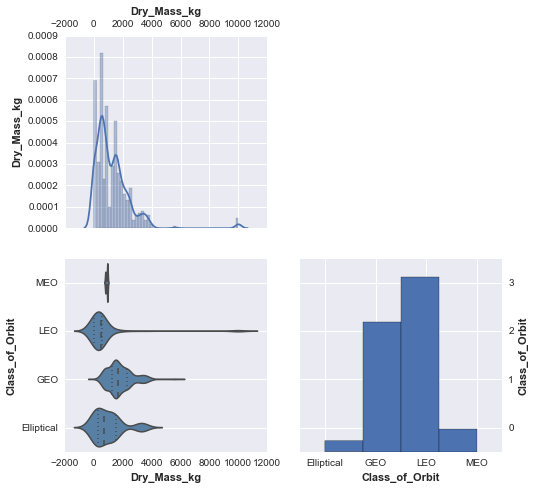

In [42]:
import bdbcontrib
import matplotlib.pyplot as plt
%matplotlib inline
fig = bdbcontrib.pairplot(satellites_bdb, 'SELECT dry_mass_kg, class_of_orbit FROM satellites',
                    generator_name='satellites_cc')

Bayesian Modeling
====

Before you can use BQL modelling for your data, you must use register a metamodel, such as the Crosscat metamodel with which the `.bdb` file was built.

In [16]:
import crosscat.LocalEngine
import bayeslite.crosscat
crosscat_engine = crosscat.LocalEngine.LocalEngine(seed=0)
crosscat_metamodel = bayeslite.crosscat.CrosscatMetamodel(crosscat_engine)
bayeslite.bayesdb_register_metamodel(satellites_bdb, crosscat_metamodel)

We can now begin to ask BayesDB questions about the implications of the data.

### Dependence Between Columns
Often the first question we want to ask, especially if we are relatively clueless about the data, is which columns are most likely dependent on each other. 

One of the most common statistical techniques for detecting dependence between variables is using correlation coefficients. BayesDB has a more powerful notion of dependence called `DEPENDENCE PROBABILITY`, which is the degree of belief that two columns have some dependence. First let us see the probability that each column depdnds on `perigee_km`, and `longitude_radians_of_geo`.

In [37]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
ESTIMATE
    *, DEPENDENCE PROBABILITY WITH perigee_km AS "Probability of Dependence with Perigee"
    FROM COLUMNS OF satellites_cc
    ORDER BY "Probability of Dependence with Perigee" DESC LIMIT 10;
'''))
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
ESTIMATE
    *, DEPENDENCE PROBABILITY WITH longitude_radians_of_geo AS "Probability of Dependence with Longitude Radians"
    FROM COLUMNS OF satellites_cc
    ORDER BY "Probability of Dependence with Longitude Radians" DESC LIMIT 10;
'''))

                        name | Probability of Dependence with Perigee
-----------------------------+---------------------------------------
              Class_of_Orbit |                                    1.0
               Type_of_Orbit |                                    1.0
                  Perigee_km |                                      1
                   Apogee_km |                                    1.0
Source_Used_for_Orbital_Data |                                    1.0
         Inclination_radians |                                    1.0
                     Purpose |                               0.984375
              Period_minutes |                               0.984375
                       Users |                                0.96875
                 Launch_Site |                                0.96875
                    name | Probability of Dependence with Longitude Radians
-------------------------+-------------------------------------------------
longitud

Let us now view all pairwise dependencies probabilities using the `heatmap` plotting utility. The entries along the diagnoal are 1, since each variable is dependent with itself. Notice that `DEPENDENCE PROBABILITY` determines a richer network of relationships than standard measures of correlation.

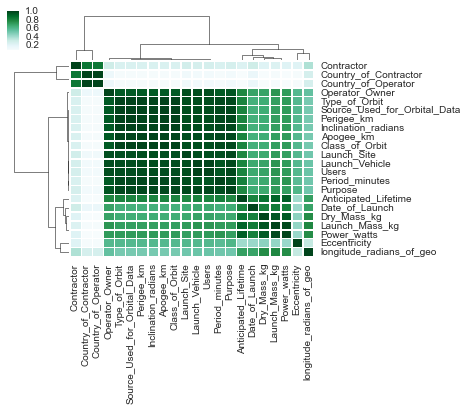

In [38]:
clustermap = bdbcontrib.heatmap(satellites_bdb,
    'ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF satellites_cc')

### Inferring Missing Data

Inferring is like imputing. `INFER` produces a summary value for a missing (`NULL`) entry. If we use the `EXPLICIT` keyword, we can re-infer present values.

Finally, we need to tell BayesDB which values to treat as missing, `NULL`. Different datasets use different markers for missing data, this dataset uses `'NaN'`. To convert all instances of `'NaN'` to SQL `NULL`, we use the `nullify` utility, followed by the table, followed by the value to convert to `NULL`.

In [47]:
bdbcontrib.nullify(satellites_bdb, 'satellites', 'NaN')

First we will impute missing values of `type_of_orbit`. Let us see how many values are missing.

In [48]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))

"COUNT"(*)
----------
      1938


We will use the `INFER EXPLICIT` query to impute all missing values, and let BayesDB tell us the belief of its reported value. First we will pull out `anticipated_lifetime`, `perigee_km`, `period_minutes`, and `class_of_orbit` exactly as they appear in the table. Next we will use the special BQL expression `PREDICT <col_name> CONFIDENCE <conf_name>`, which will retrun two values: first, a prediction for `<col_name>` and second a confidence level for the predicted value.

In [ ]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute('''
INFER EXPLICIT
    PREDICT type_of_orbit AS inferred_orbit_type CONFIDENCE inferred_orbit_type_conf
    FROM satellites_cc
    WHERE type_of_orbit IS NULL
'''))